# Recurrent Neural Network

## Example 1 : Bike Sharing Dataset

This dataset contains the hourly and daily count of rental bikes between the years 2011 and 2012 in the Capital bike share system with the corresponding weather and seasonal information.

Source: https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

In [ ]:
import pandas as pd

path = "bike_rental_day.csv"
df = pd.read_csv(path)

df.head()


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


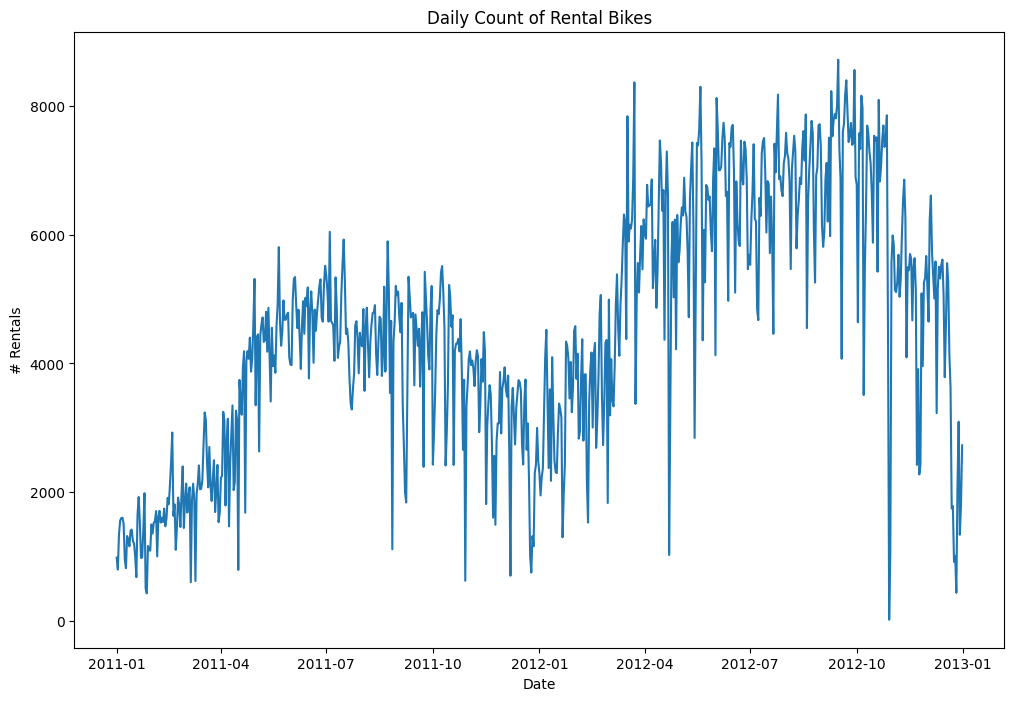

In [ ]:
import matplotlib.pyplot as plt

df['dteday'] = pd.to_datetime(df['dteday'])
df["cnt"] = pd.to_numeric(df["cnt"])

df.set_index('dteday', inplace=True)

plt.figure(figsize=(12,8))
plt.plot(df['cnt'])
plt.title('Daily Count of Rental Bikes')
plt.xlabel('Date')
plt.ylabel('# Rentals')
plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Use these features
features = ["temp", "atemp", "hum", "windspeed", "cnt"] # for testing purposes, could also take season, working day, etc

data = df[features].values

# Scale features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Convert to sequences for time-series forecasting
def create_sequences(data, window=24): # uses 24 steps in the past
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window, -1])   # next-day bike demand
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, window=40) # uses 40 days in the past "for each x, I want to train it on the last 40 days"
X.shape, y.shape

((691, 40, 5), (691,))

In [ ]:
y[0]

np.float64(1538.0)

## Splitting the training data

Because we're working with sequential data, we don't want to split it in the middle of a sequential time series. So we split it on the first 80% of the data

In [ ]:
split = int(0.8 * len(X)) # because we're working with sequential data
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build LSTM model
model = models.Sequential([
    layers.Input(shape=(X.shape[1], X.shape[2])),
    # layers.LSTM(64, return_sequences=True), # need return sequences for all non-final RNNs
        # results in loss of 0.53, so Tariq tried the next two in class demo
    # layers.SimpleRNN(64, return_sequences=True), # let's try this one instead
        # results in loss of 0.60, results are "stupid"
    layers.GRU(64, return_sequences=True),
        # results in loss of 0.43
    layers.LSTM(32), # no return sequence here because it's the last
    # can't specify activation function for RNN, uses sigmoid automatically
    layers.Dense(16, activation="relu"), # using relu for the dense layer only
    layers.Dense(1)
])


model.compile(optimizer="adam", loss="mse")

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5),
               ModelCheckpoint("bike_sharing_best_model.keras",
                                                          monitor='val_accuracy',
                                                          save_best_only=True)
               ],
    verbose=1
)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 0.5980 - val_loss: 0.5611
Epoch 2/20
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1620

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.2533 - val_loss: 0.5315
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.2057 - val_loss: 0.5739
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.2282 - val_loss: 0.5251
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1966 - val_loss: 0.5352
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.1883 - val_loss: 0.5292
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.1911 - val_loss: 0.5237
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.2043 - val_loss: 0.5318
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.2345 - val_loss: 0.5291
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.1925 - val_loss: 0.5427
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - loss: 0.1950 - val_loss: 0.5318
Epoch 12/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.1812 - val_loss: 0.5376


Above doesn't take long to run because the input is only a history of 40 days.

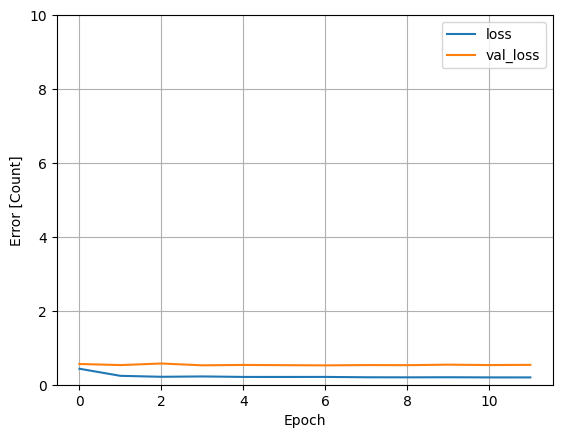

In [ ]:

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [Count]')
plt.legend()
plt.grid(True)

In [ ]:
pred = model.predict(X_test)
loss = model.evaluate(X_test, y_test, verbose=0)
print("Loss: ", loss)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Loss:  0.5376490354537964


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


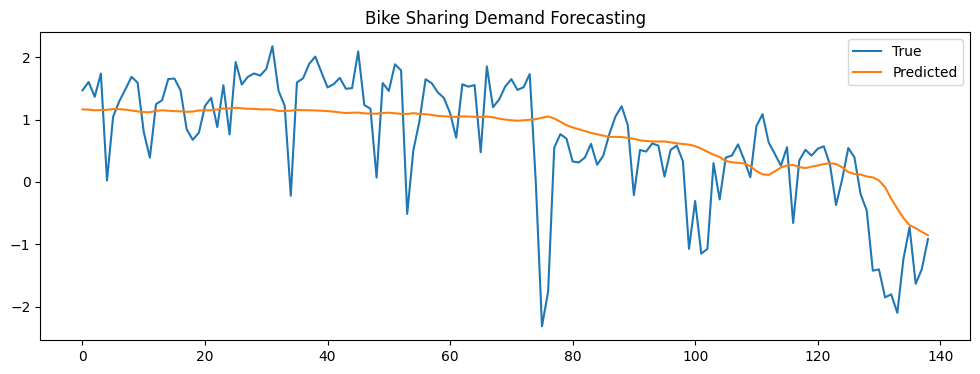

In [ ]:
import matplotlib.pyplot as plt

pred = model.predict(X_test)

plt.figure(figsize=(12,4))
plt.plot(y_test, label="True")
plt.plot(pred, label="Predicted")
plt.title("Bike Sharing Demand Forecasting")
plt.legend()
plt.show()


## Now let's do something that RNN was made for

# Jena Climate Weather Forecasting using LSTM

Jena Climate is weather timeseries dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany. The dataset is made up of 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. This dataset covers data from January 1st 2009 to December 31st 2016.



This example demonstrates multi-step weather forecasting using the Jena Climate Dataset and LSTM networks.

In [ ]:
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
# df['Date Time'] = pd.to_datetime(df['Date Time'], format='mixed')
# df.set_index('Date Time', inplace=True)
df = df.sort_index()

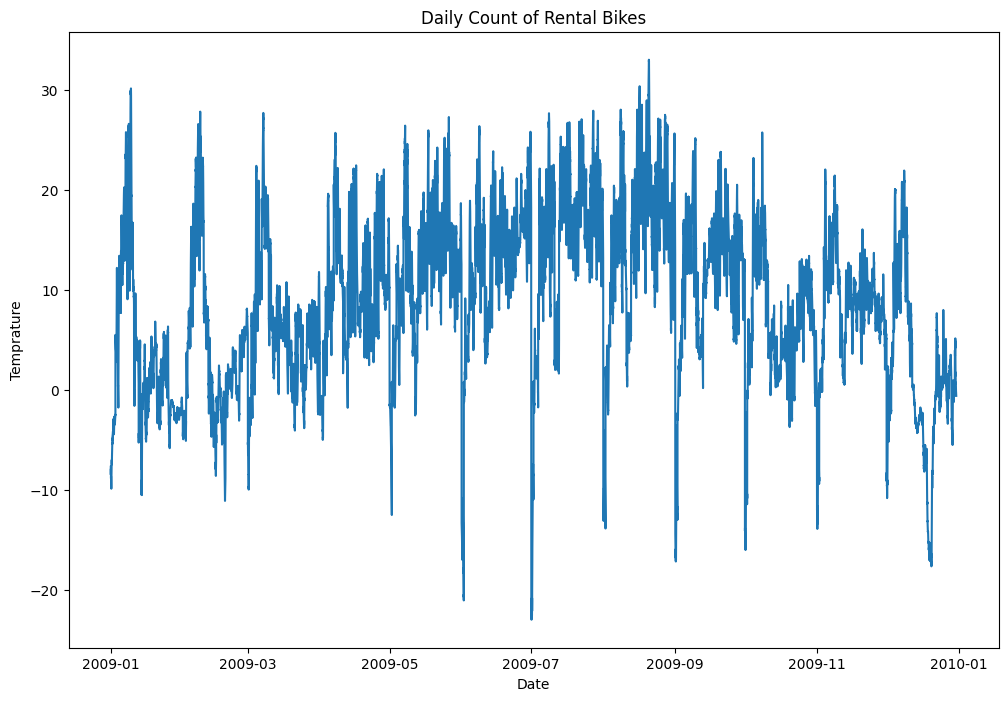

In [ ]:

dff = df.loc[(df.index >= '01.01.2009') & (df.index <= '31.12.2009')]

plt.figure(figsize=(12,8))
plt.plot(dff['T (degC)'])
plt.title('Daily Count of Rental Bikes')
plt.xlabel('Date')
plt.ylabel('Temprature')
plt.show()

In [ ]:
# Select important features
features = ['T (degC)', 'p (mbar)', 'rh (%)']
data = df[features].values

# Normalize features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences (past 72 timesteps -> predict next temperature)
def create_dataset(sequence, window=72):
    X, y = [], []
    for i in range(len(sequence) - window):
        X.append(sequence[i:i+window])
        y.append(sequence[i+window, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(data_scaled, 72)
X.shape, y.shape

((420479, 72, 3), (420479,))

In [ ]:
# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
# Build LSTM model
model = models.Sequential([
    layers.Input(shape=(X.shape[1], X.shape[2])),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32), # no need for more than 2 layers
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 72, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

Epoch 1/10
8410/8410 ━━━━━━━━━━━━━━━━━━━━ 548s 65ms/step - loss: 0.0019 - val_loss: 6.3645e-05
Epoch 2/10
8410/8410 ━━━━━━━━━━━━━━━━━━━━ 545s 65ms/step - loss: 2.6728e-05 - val_loss: 1.5296e-05
Epoch 3/10
8410/8410 ━━━━━━━━━━━━━━━━━━━━ 558s 64ms/step - loss: 1.6863e-05 - val_loss: 3.0363e-05
Epoch 4/10
8410/8410 ━━━━━━━━━━━━━━━━━━━━ 543s 65ms/step - loss: 1.6288e-05 - val_loss: 1.5651e-05
Epoch 5/10
8410/8410 ━━━━━━━━━━━━━━━━━━━━ 562s 65ms/step - loss: 1.4697e-05 - val_loss: 3.4002e-05
Epoch 6/10
8410/8410 ━━━━━━━━━━━━━━━━━━━━ 543s 65ms/step - loss: 1.4579e-05 - val_loss: 1.3812e-05
Epoch 7/10
8410/8410 ━━━━━━━━━━━━━━━━━━━━ 544s 65ms/step - loss: 1.4435e-05 - val_loss: 1.2638e-05
Epoch 8/10
8410/8410 ━━━━━━━━━━━━━━━━━━━━ 543s 65ms/step - loss: 1.3701e-05 - val_loss: 1.3440e-05
Epoch 9/10
8410/8410 ━━━━━━━━━━━━━━━━━━━━ 565s 65ms/step - loss: 1.3753e-05 - val_loss: 1.1756e-05
Epoch 10/10
8410/8410 ━━━━━━━━━━━━━━━━━━━━ 560s 65ms/step - loss: 1.3884e-05 - val_loss: 1.4020e-05


Each epoch takes around 10 minutes

2628/2628 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step


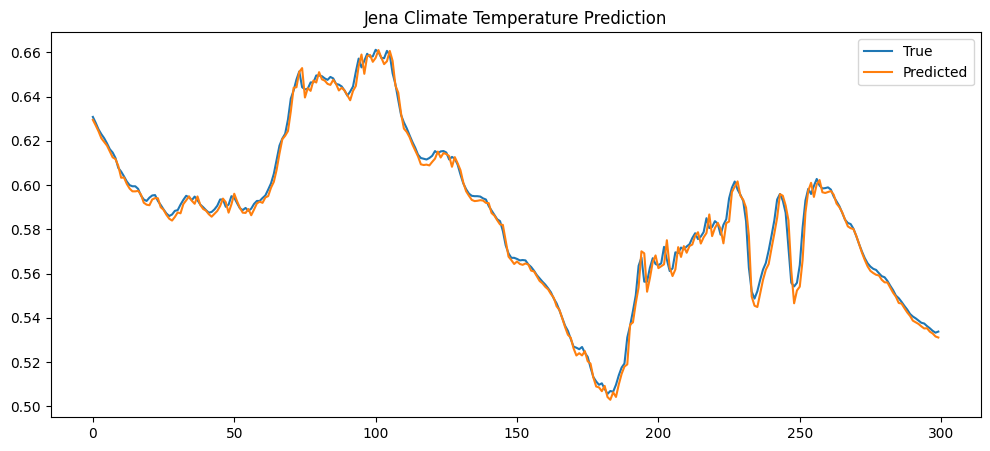

In [ ]:
# Predict
pred = model.predict(X_test)

plt.figure(figsize=(12,5))
plt.plot(y_test[:300], label='True')
plt.plot(pred[:300], label='Predicted')
plt.legend()
plt.title('Jena Climate Temperature Prediction')
plt.show()

# WOW


# Spoken Digit Recognition (0–9) Using LSTM + MFCC

In [ ]:
# 2) Download the dataset
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4260 (delta 25), reused 8 (delta 8), pack-reused 4212 (from 1)
Receiving objects: 100% (4260/4260), 30.38 MiB | 17.97 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

DATA_DIR = "/content/free-spoken-digit-dataset/recordings"

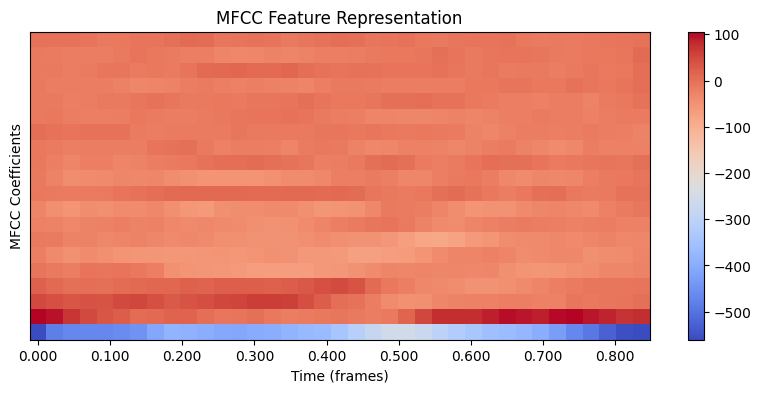

In [ ]:
path="/content/free-spoken-digit-dataset/recordings/0_george_1.wav"
signal, sr = librosa.load(path, sr=8000)

mfcc = librosa.feature.mfcc(
    y=signal, sr=sr, n_mfcc=20, n_fft=512, hop_length=128
)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis="time")
plt.colorbar()
plt.title("MFCC Feature Representation")
plt.ylabel("MFCC Coefficients")
plt.xlabel("Time (frames)")
plt.show()

In [ ]:
from IPython.display import Audio

Audio(path)

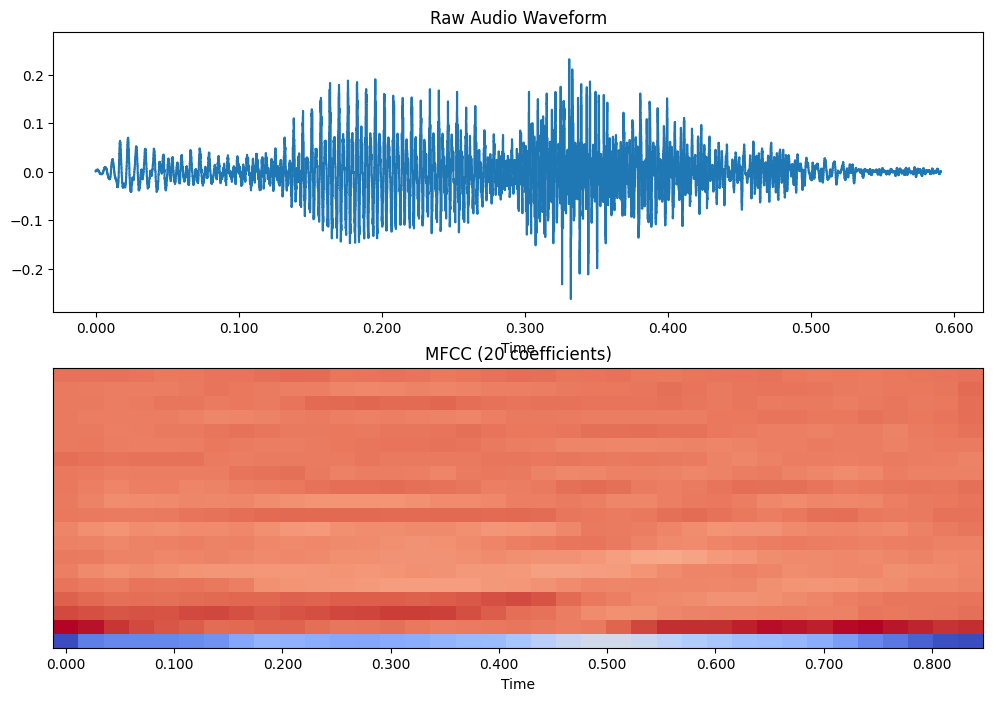

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# waveform
librosa.display.waveshow(signal, sr=sr, ax=ax[0])
ax[0].set_title("Raw Audio Waveform")

librosa.display.specshow(mfcc, x_axis="time", ax=ax[1])
ax[1].set_title("MFCC (20 coefficients)")
plt.show()

In [ ]:
# 2) Load MFCC features for all files
def load_fsdd():
    X, y = [], []

    for fname in os.listdir(DATA_DIR):
        if fname.endswith(".wav"):
            digit = int(fname.split("_")[0])
            path = os.path.join(DATA_DIR, fname)

            signal, sr = librosa.load(path, sr=8000)

            mfcc = librosa.feature.mfcc(
                y=signal, sr=sr, n_mfcc=20,
                n_fft=512, hop_length=128
            )

            X.append(mfcc.T)
            y.append(digit)

    return X, np.array(y)

X, y = load_fsdd()
print("Loaded samples:", len(X))
print("Labels shape:", y.shape)

Loaded samples: 3000
Labels shape: (3000,)


In [ ]:
# 3) Pad sequences to same length
X = pad_sequences(X, padding="post", dtype="float32")
print("X shape:", X.shape)

X shape: (3000, 143, 20)


In [ ]:
# 4) One-hot labels
num_classes = 10
y = tf.keras.utils.to_categorical(y, num_classes)


In [ ]:
# 5) Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
X[0]

array([[-362.29788  ,   99.633194 ,   63.65258  , ...,    2.5950098,
         -23.94551  ,    0.9806867],
       [-285.88687  ,   91.64686  ,   58.368397 , ...,   -2.9936378,
         -29.103863 ,   -2.2843027],
       [-262.1207   ,   82.64128  ,   50.874992 , ...,   -8.51673  ,
         -23.274405 ,   -2.476588 ],
       ...,
       [   0.       ,    0.       ,    0.       , ...,    0.       ,
           0.       ,    0.       ],
       [   0.       ,    0.       ,    0.       , ...,    0.       ,
           0.       ,    0.       ],
       [   0.       ,    0.       ,    0.       , ...,    0.       ,
           0.       ,    0.       ]], dtype=float32)

In [ ]:
# 6) LSTM model

model = tf.keras.Sequential([
    layers.Input(shape=(X.shape[1], X.shape[2])),
    layers.Masking(mask_value=0.),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(64, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 143, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 143, 128)       │        76,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,506 (509.79 KB)

 Trainable params: 130,506 (509.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 7) Train

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32
)


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.9995 - loss: 0.0043 - val_accuracy: 0.9833 - val_loss: 0.0622
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 341ms/step - accuracy: 0.9998 - loss: 0.0020 - val_accuracy: 0.9833 - val_loss: 0.0631
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 340ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9833 - val_loss: 0.0622
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 340ms/step - accuracy: 0.9999 - loss: 0.0027 - val_accuracy: 0.9750 - val_loss: 0.1010
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 341ms/step - accuracy: 0.9988 - loss: 0.0032 - val_accuracy: 0.9750 - val_loss: 0.0838
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 309ms/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 0.9812 - val_loss: 0.0754
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 334ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9812 - val_loss: 0.0788
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 316ms/step - accuracy: 1.0000 - loss: 6.4867e-04 - val_

In [ ]:
# 8) Evaluate
loss, acc = model.evaluate(X_test, y_test)
print("Test accuracy:", acc)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9860 - loss: 0.0455
Test accuracy: 0.9916666746139526


In [ ]:
# 9) Predict a single sample
import random
i = random.randint(0, len(X_test)-1)
pred = np.argmax(model.predict(X_test[i:i+1]))
true = np.argmax(y_test[i])

print("True:", true, "Predicted:", pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
True: 0 Predicted: 0
